This is some interesting maths...

$\sum{}_{i=1}^{n} i = \frac{n(n+1)}{2}$

In [2]:
#imports
# %matplotlib widget
# %matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from IPython.display import display_markdown
import datetime
from datetime import datetime as dt
from numpy import nan

from import_OMNI import read_OMNI, nan_value
from import_ACE import read_ACE
from import_cdaweb import read_CDAWeb
from entropy import H, MI, CMI, entropy_matrix
from storm_selection import findSeq
from import_RTSW import read_RTSW_ACE


In [3]:
# storm = read_OMNI(
#     filepath="../OMNI/datasets/test_2.txt",
#     formatpath="../OMNI/data_format/test_2_format.txt",
# )
# # for column in list(df)[1:]:
#     # plt.plot(df["Datetime"], df[column], label=column)
# plt.plot(df["Datetime"], df["BZ"], label="BZ")
# # plt.plot(df["Datetime"], df["SYM/H"], label="SYM/H")
# # plt.hist(storm["SYM/H"], 150)
# plt.legend()
# plt.show()

In [19]:
def markdown_entropy_matrix(df, bins=200, ignore_columns=[0], use_scipy=False, use_sklearn=False):
    em = entropy_matrix(df, bins=bins, ignore_columns=ignore_columns, use_scipy=use_scipy, use_sklearn=use_sklearn)

    display_markdown(
f'''| |{"|".join(df.columns[1:])}|
{"".join(["|:-"] * len(df.columns))}|
{"\n".join([f"|{column_name}|{"|".join(map(lambda x: "%.2f" % x, em[i]))}|" for i, column_name in enumerate(df.columns[1:])])}
|Number of datapoints|{"|".join([str(len(df[column])) for column in df.columns[1:]])}|
''',
    raw = True
    )

In [5]:
# markdown_entropy_matrix(df)

c:\Users\Aarnav\Downloads\UROP2024\UROP2024\src\import_OMNI.py:60: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(


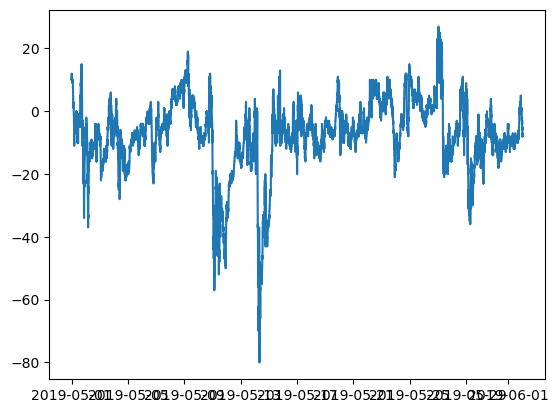

In [6]:
df = read_OMNI(
    filepath="../OMNI/datasets/2019_March_data.txt",
    formatpath="../OMNI/data_format/2019_March_data_format.txt",
)
plt.plot(df["Datetime"], df["SYM/H"], label="SYM/H")
plt.show()

In [7]:
lower_thresh, upper_thresh = 20, 50
inds, ranges=findSeq(-df["SYM/H"],lower_thresh,upper_thresh,6*60, return_ranges=True)
# plt.plot(df["Datetime"], df["SYM/H, nT"])

Min / max thresholds are: 20.00 , 50.00
3 sequences found.
Joining two sequences next to each other (within the threshold).


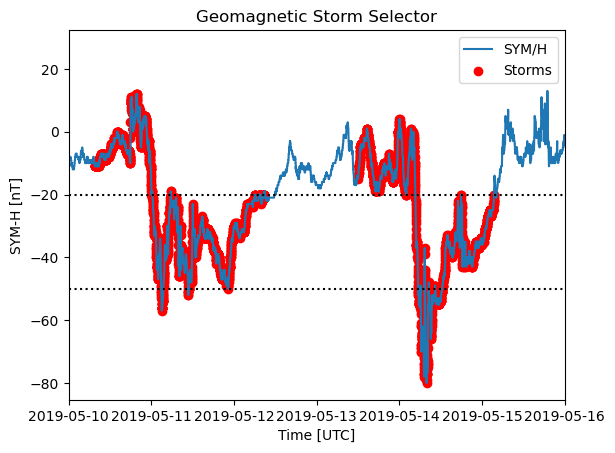

In [8]:
plt.figure()
plt.plot(df["Datetime"], df["SYM/H"], label="SYM/H")
plt.scatter(df["Datetime"].iloc[inds],df["SYM/H"].iloc[inds],color='r',label='Storms')
plt.axhline(-lower_thresh,color='k',linestyle=':')
plt.axhline(-upper_thresh,color='k',linestyle=':')
plt.title('Geomagnetic Storm Selector')
plt.xlabel('Time [UTC]')
plt.ylabel('SYM-H [nT]')
plt.xlim(datetime.datetime(2019, 5, 10), datetime.datetime(2019, 5, 16))
plt.legend()
plt.show()

In [9]:
storm_entropies = [H(df["SYM/H"].iloc[range(storm[0], storm[1])]) for storm in ranges]

print(f"Nominal SYM/H entropy: {H(df["SYM/H"])}")
print(f"Storm SYM/H entropies: {storm_entropies} \nAverage storm entropy (per storm): {sum(storm_entropies)/len(storm_entropies)}")
print(f"Storm entropies calculated taking storms as a set of datapoints: {H(df["SYM/H"].iloc[inds])}")
# we can initially discern a large increase in information describing SYM/H
print("Entropy Matrix for storms:")
markdown_entropy_matrix(df.iloc[inds])
print("Entropy Matrix for all data:")
markdown_entropy_matrix(df)

Nominal SYM/H entropy: 5.3815728793369155
Storm SYM/H entropies: [5.5921725345894595, 5.818315309802384] 
Average storm entropy (per storm): 5.705243922195922
Storm entropies calculated taking storms as a set of datapoints: 5.987156034385624
Entropy Matrix for storms:


| |AE-index|AL-index|AU-index|SYM/D|SYM/H|ASY/D|ASY/H|
|:-|:-|:-|:-|:-|:-|:-|:-|
|AE-index|6.53|3.00|2.49|0.99|1.91|1.67|1.86|
|AL-index|3.00|6.09|1.97|0.88|1.74|1.49|1.67|
|AU-index|2.49|1.97|6.49|0.89|1.72|1.47|1.72|
|SYM/D|0.99|0.88|0.89|3.96|1.16|1.00|1.08|
|SYM/H|1.91|1.74|1.72|1.16|5.99|1.66|1.85|
|ASY/D|1.67|1.49|1.47|1.00|1.66|5.75|1.67|
|ASY/H|1.86|1.67|1.72|1.08|1.85|1.67|6.02|
|Number of datapoints|46080|46080|46080|46080|46080|46080|46080|


Entropy Matrix for all data:


| |AE-index|AL-index|AU-index|SYM/D|SYM/H|ASY/D|ASY/H|
|:-|:-|:-|:-|:-|:-|:-|:-|
|AE-index|5.14|1.83|1.43|0.24|0.47|0.39|0.54|
|AL-index|1.83|4.58|0.78|0.21|0.43|0.35|0.48|
|AU-index|1.43|0.78|5.46|0.22|0.47|0.35|0.50|
|SYM/D|0.24|0.21|0.22|3.27|0.24|0.22|0.21|
|SYM/H|0.47|0.43|0.47|0.24|5.38|0.40|0.52|
|ASY/D|0.39|0.35|0.35|0.22|0.40|5.18|0.38|
|ASY/H|0.54|0.48|0.50|0.21|0.52|0.38|5.11|
|Number of datapoints|46080|46080|46080|46080|46080|46080|46080|


In [10]:
# evaluating average entropies of all stats in a storm
stormy_H = np.array([H(df[column].iloc[inds]) for column in list(df)[1:]])

nominal_H =  np.array([H(df[column]) for column in list(df)[1:]])

stormy_H - nominal_H

array([1.38648473, 1.50780848, 1.03185059, 0.69040972, 0.60558316,
       0.57245759, 0.91549906])

In [11]:
def find_bin_num(func, default = 100):
    bin_num = default
    while not np.isclose(func(bin_num), func(bin_num-50)):
        bin_num += 100
    return bin_num


In [12]:
def gradient_desc(f, initial = 100, step_size = 100, weight = 1):
    x = initial
    grad = f(x+step_size) - f(x)
    while not np.isclose(grad,0):
        print(x, grad)
        x += int(grad*step_size*weight)
        grad = f(x+step_size) - f(x)
        
    return x+step_size

In [13]:
# [find_bin_num(lambda x: H(df[column], bins=x)) for column in list(df)[1:]]

In [20]:
df2 = read_ACE("../ACE/ACE_Browse_Data.txt")
df2.columns, MI(df2[df2.columns.difference(["ACE_epoch_time"])], df2["B_rtn_t_MAG"], use_sklearn=True)

(Index(['ACE_epoch_time', 'B_rtn_r_MAG', 'B_rtn_t_MAG', 'B_rtn_n_MAG',
        'B_rtn_theta_MAG', 'B_rtn_phi_MAG', 'B_gse_x_MAG', 'B_gse_y_MAG',
        'B_gse_z_MAG', 'B_gse_theta_MAG', 'B_gse_phi_MAG', 'B_gsm_x_MAG',
        'B_gsm_y_MAG', 'B_gsm_z_MAG', 'B_gsm_theta_MAG', 'B_gsm_phi_MAG',
        'B_magnitude_MAG'],
       dtype='object'),
 array([ 1.21985714,  0.07688055,  0.13647978,  2.80176392,  0.05911008,
         0.89137907,  0.04102731,  0.13647444,  1.47115435,  0.06516704,
         0.49301371,  0.06040666,  1.34625825,  0.13604812, 10.17837691,
         0.09187053]))

In [21]:
markdown_entropy_matrix(df2, use_sklearn=True)

| |B_rtn_r_MAG|B_rtn_t_MAG|B_rtn_n_MAG|B_rtn_theta_MAG|B_rtn_phi_MAG|B_gse_x_MAG|B_gse_y_MAG|B_gse_z_MAG|B_gse_theta_MAG|B_gse_phi_MAG|B_gsm_x_MAG|B_gsm_y_MAG|B_gsm_z_MAG|B_gsm_theta_MAG|B_gsm_phi_MAG|B_magnitude_MAG|
|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|
|B_rtn_r_MAG|10.16|0.14|0.04|0.09|1.24|6.46|0.13|0.04|0.09|1.23|6.46|0.13|0.04|0.10|1.22|0.30|
|B_rtn_t_MAG|0.14|10.18|0.06|0.09|1.35|0.14|2.80|0.06|0.08|1.22|0.14|1.47|0.07|0.04|0.89|0.49|
|B_rtn_n_MAG|0.04|0.06|10.14|1.67|0.04|0.04|0.05|2.28|1.33|0.03|0.04|0.06|1.01|0.74|0.04|0.30|
|B_rtn_theta_MAG|0.09|0.09|1.67|10.29|0.02|0.09|0.09|1.34|2.31|0.01|0.09|0.05|0.73|0.92|0.03|0.03|
|B_rtn_phi_MAG|1.24|1.35|0.04|0.02|10.30|1.24|1.21|0.04|0.02|3.77|1.24|0.89|0.04|0.04|2.43|0.07|
|B_gse_x_MAG|6.46|0.14|0.04|0.09|1.24|10.16|0.13|0.04|0.09|1.24|10.16|0.13|0.04|0.10|1.23|0.30|
|B_gse_y_MAG|0.13|2.80|0.05|0.09|1.21|0.13|10.18|0.06|0.09|1.35|0.13|1.55|0.06|0.04|0.92|0.49|
|B_gse_z_MAG|0.04|0.06|2.28|1.34|0.04|0.04|0.06|10.14|1.67|0.04|0.04|0.06|1.10|0.79|0.04|0.30|
|B_gse_theta_MAG|0.09|0.08|1.33|2.31|0.02|0.09|0.09|1.67|10.29|0.02|0.09|0.05|0.78|1.02|0.03|0.03|
|B_gse_phi_MAG|1.23|1.22|0.03|0.01|3.77|1.24|1.35|0.04|0.02|10.30|1.24|0.92|0.04|0.03|2.53|0.07|
|B_gsm_x_MAG|6.46|0.14|0.04|0.09|1.24|10.16|0.13|0.04|0.09|1.24|10.16|0.13|0.04|0.10|1.23|0.30|
|B_gsm_y_MAG|0.13|1.47|0.06|0.05|0.89|0.13|1.55|0.06|0.05|0.92|0.13|10.18|0.04|0.09|1.35|0.46|
|B_gsm_z_MAG|0.04|0.07|1.01|0.73|0.04|0.04|0.06|1.10|0.78|0.04|0.04|0.04|10.14|1.65|0.04|0.31|
|B_gsm_theta_MAG|0.10|0.04|0.74|0.92|0.04|0.10|0.04|0.79|1.02|0.03|0.10|0.09|1.65|10.29|0.02|0.03|
|B_gsm_phi_MAG|1.22|0.89|0.04|0.03|2.43|1.23|0.92|0.04|0.03|2.53|1.23|1.35|0.04|0.02|10.30|0.07|
|B_magnitude_MAG|0.30|0.49|0.30|0.03|0.07|0.30|0.49|0.30|0.03|0.07|0.30|0.46|0.31|0.03|0.07|10.06|
|Number of datapoints|105120|105120|105120|105120|105120|105120|105120|105120|105120|105120|105120|105120|105120|105120|105120|105120|


In [16]:
MI(df2["B_rtn_r_MAG"], df2["B_rtn_r_MAG"], use_sklearn=True)

array([10.15983717])

In [22]:
mag_df, swepam_df = read_CDAWeb("../CDAWeb/ac_h0s_swe_20190101000053_20190529235924.cdf", mag_file_path="../CDAWeb/ac_h3s_mfi_20190101000000_20190529235959.cdf")
mag2 = mag_df.resample("64s", on="Epoch", label="left").mean().reset_index()


In [23]:
L1_data = pd.concat([mag2, swepam_df[swepam_df.columns[1:]]], axis=1)
# L1_data.set_index('Epoch', inplace=True)
L1_data.columns, L1_data.min()["Epoch"], L1_data.max()["Epoch"]

(Index(['Epoch', 'Br RTN', 'Bt RTN', 'Bn RTN', 'Np', 'Vp', 'Tpr'], dtype='object'),
 Timestamp('2019-01-01 00:00:00'),
 Timestamp('2019-05-29 23:58:56'))

In [30]:
def storm_analysis(indicies_data, L1_data, max_min_diff = 60, min_min_diff = 5):
    window_width = len(indicies_data)
    rolling_data = L1_data.rolling(window=window_width)

    to_test = []
    storm_start = indicies_data["Datetime"].min()
    for convolution in rolling_data:
        minutes_diff = (storm_start - convolution["Epoch"].min()).total_seconds()//60
        if convolution.shape[0] != len(indicies_data) or minutes_diff > max_min_diff or minutes_diff < min_min_diff:
            to_test.append(False)
        else:
            to_test.append(True)

    to_test = np.array(to_test)
    num_to_test = to_test.sum()

    MI_matrices = []
    times = []
    for i, convolution in enumerate(rolling_data):
        if to_test[i]:
            print(f"\r{100*(len(MI_matrices))/(num_to_test):.2f}% complete, analysing window starting on {convolution["Epoch"].min()}", end="\r")
            MI_matrix = np.array([MI(convolution[convolution.columns.difference(["Epoch"])], indicies_data[col_j], use_sklearn=True) for col_j in indicies_data.columns[1:]])
            MI_matrices.append(MI_matrix)
            times.append(convolution["Epoch"].min())
    MI_matrices = np.array(MI_matrices)
    times = np.array(times)
    return MI_matrices, times

In [31]:
storm_data = [df.iloc[range(storm[0], storm[1])] for storm in ranges]
storm = storm_data[0]

MI_matrices, times = storm_analysis(storm, L1_data)

52


In [26]:
MI_matrices.shape, L1_data.columns[1:], storm.columns[1:] # just checking everything is working as expected

((52, 7, 6),
 Index(['Br RTN', 'Bt RTN', 'Bn RTN', 'Np', 'Vp', 'Tpr'], dtype='object'),
 Index(['AE-index', 'AL-index', 'AU-index', 'SYM/D', 'SYM/H', 'ASY/D', 'ASY/H'], dtype='object'))

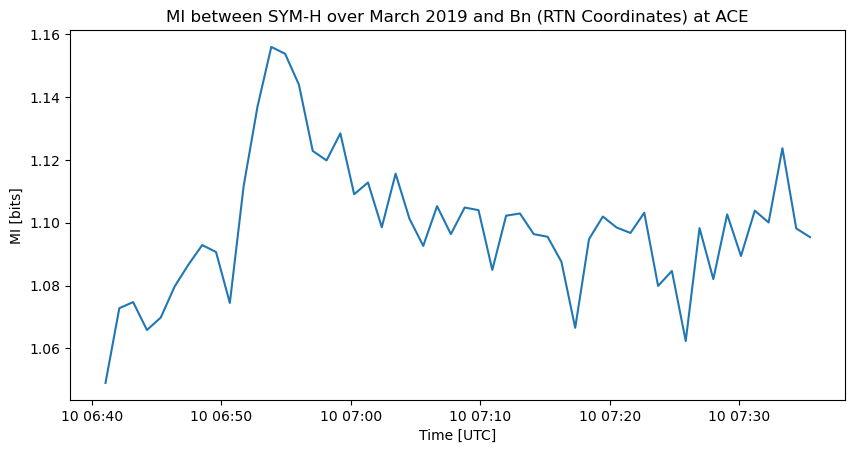

In [27]:
plt.figure(figsize=[10, 4.8])

plt.plot(times, MI_matrices[:, -3, 2]) # first number indexes the OMNI column, second indexes the ACE column
plt.title('MI between SYM-H over March 2019 and Bn (RTN Coordinates) at ACE')
plt.xlabel('Time [UTC]')
plt.ylabel('MI [bits]')
# plt.xlim(datetime.datetime(2018, 12, 31), datetime.datetime(2019, 4, 27))
plt.show() # attempt at plotting MI between Bz and SMH/H

In [28]:
# np.save("MI matrices.npy", MI_matrices)

In [29]:
max_MI_pos = np.argmax(MI_matrices[:, -3, 2])
max_MI = MI_matrices[max_MI_pos, -3, 2]
times[max_MI_pos], max_MI

(12, Timestamp('2019-05-10 06:53:52'), 1.1559283788869923)